In [96]:
import numpy as np
import os
from astropy.io import fits
from astropy import wcs
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit

In [2]:
os.getcwd()

'/home/ddunne/Documents/research/ALMA'

In [3]:
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/XMM/XMM-5/product/cubes')

xmm5_cubefiles = glob.glob("*.fits")

xmm5_cubehduls = []
for i,file in enumerate(xmm5_cubefiles):
    with fits.open(file) as hdulist:
        xmm5_cubehduls.append(hdulist)
        print("{} {}".format(i, file))

# OVERLAY RADIO CONTOURS

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


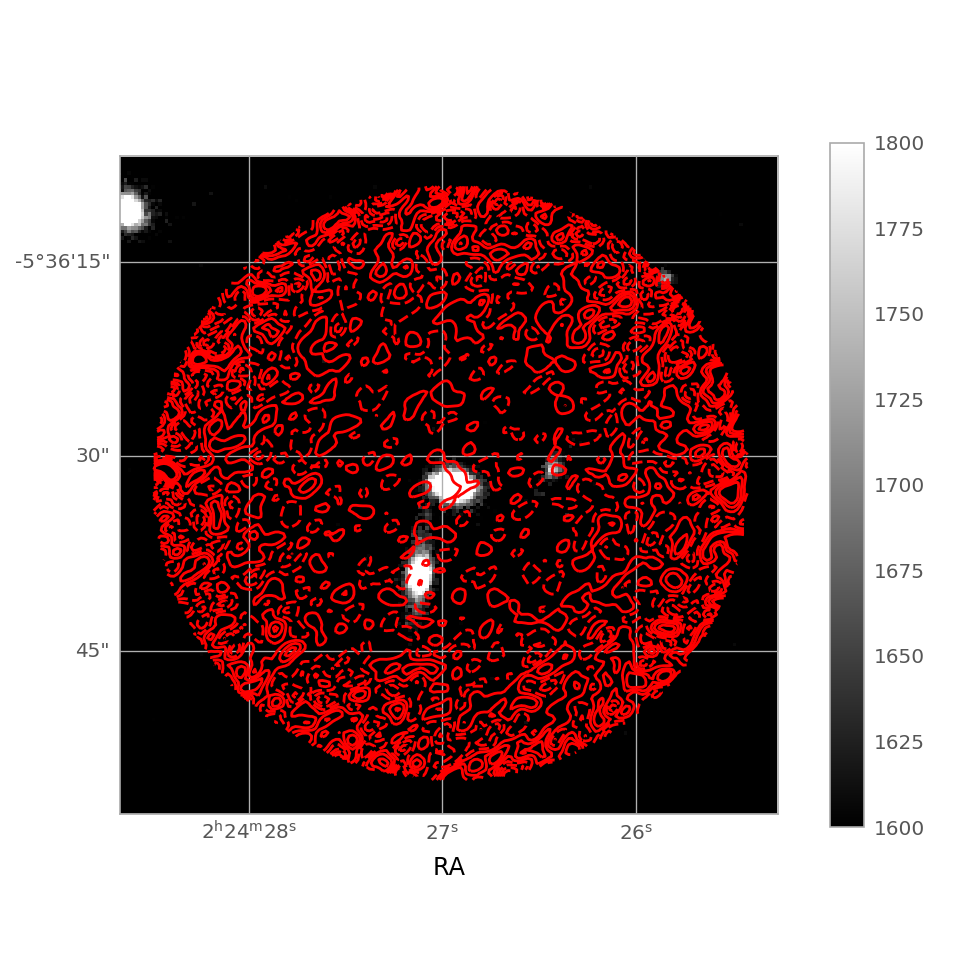

In [328]:
plot_contour_overlay((xmm5_cubefiles[1], xmm5_cubefiles[9]), 1600, 1800, (78, 118))

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


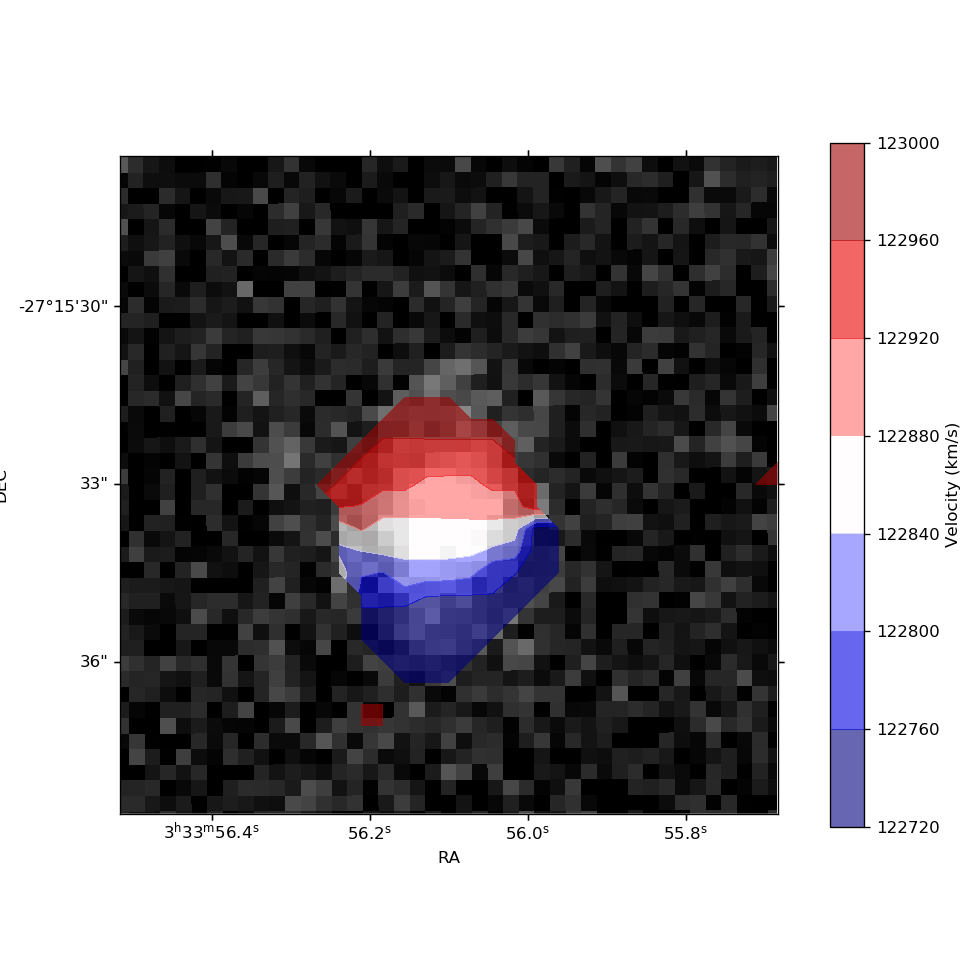

In [137]:
plot_velocity_overlay((xmm5_cubefiles[1], xmm5_cubefiles[1]), -9, 100)

In [193]:
# mark sources in the optical image to look for their counterparts in the ALMA one
opthdu = fits.open(xmm5_cubefiles[3])[0]
optdata = opthdu.data
threshold = np.ones(np.shape(optdata)) * 1100
# threshold *= (np.mean(optdata))

optsources = detect_sources(optdata, threshold, 7, connectivity=4) 
optprops = source_properties(optdata, optsources)

coords = []
for n in range(len(optprops)):
    coords.append([optprops[n].xcentroid.value, optprops[n].ycentroid.value])
    
coords = np.array(coords)

In [6]:
def plot_contour_overlay(files, optmin, optmax, lims):

    opthdu = fits.open(files[0])[0]
    momhdu = fits.open(files[1])[0]

    optwcs = wcs.WCS(opthdu.header)
    momwcs = wcs.WCS(momhdu.header)

    momwcs = momwcs.sub(['celestial'])

    %matplotlib notebook

    momdata = momhdu.data[0,0,:,:]
    mommax = np.nanmax(momdata)
    momstd = np.nanstd(momdata)
    levels = np.ones(8)*mommax
    stds = np.arange(10, 2, step=-1)*momstd
    levels = (levels - stds)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection=momwcs)
    ax.contour(momdata, colors='red', levels=levels)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    opt_transform = ax.get_transform(optwcs)
    
    im = ax.imshow(opthdu.data, cmap=plt.cm.gray, transform=opt_transform, vmin=optmin, vmax=optmax)

    cbar = plt.colorbar(im, fraction=0.046, pad=0.07)

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
#     ax.set_xlim([*lims])
#     ax.set_ylim([*lims])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [7]:
def plot_velocity_overlay(files, optmin, optmax):

    opthdu = fits.open(files[0])[0]
    momhdu = fits.open(files[1])[0]

    optwcs = wcs.WCS(opthdu.header)
    momwcs = wcs.WCS(momhdu.header)

    momwcs = momwcs.sub(['celestial'])

    %matplotlib notebook

    momdata = momhdu.data[0,0,:,:]
    mommax = np.nanmax(momdata)
    momstd = np.nanstd(momdata)
    levels = np.ones(8)*mommax
    stds = np.arange(10, 2, step=-1)*momstd
    levels = (levels - stds)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection=momwcs)
    cont = ax.contourf(momdata, cmap=plt.cm.seismic, alpha=0.6)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    opt_transform = ax.get_transform(optwcs)
    
    im = ax.imshow(opthdu.data, cmap=plt.cm.gray, transform=opt_transform, vmin=optmin, vmax=optmax)

    cbar = plt.colorbar(cont, fraction=0.046, pad=0.07)
    
    cbar.ax.set_ylabel("Velocity (km/s)")

    ax.set_xlabel('RA')
    ax.set_ylabel('DEC')
    ax.set_xlim([83, 113])
    ax.set_ylim([83, 113])

moment 0 plot for XMM 8 (two different lines)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


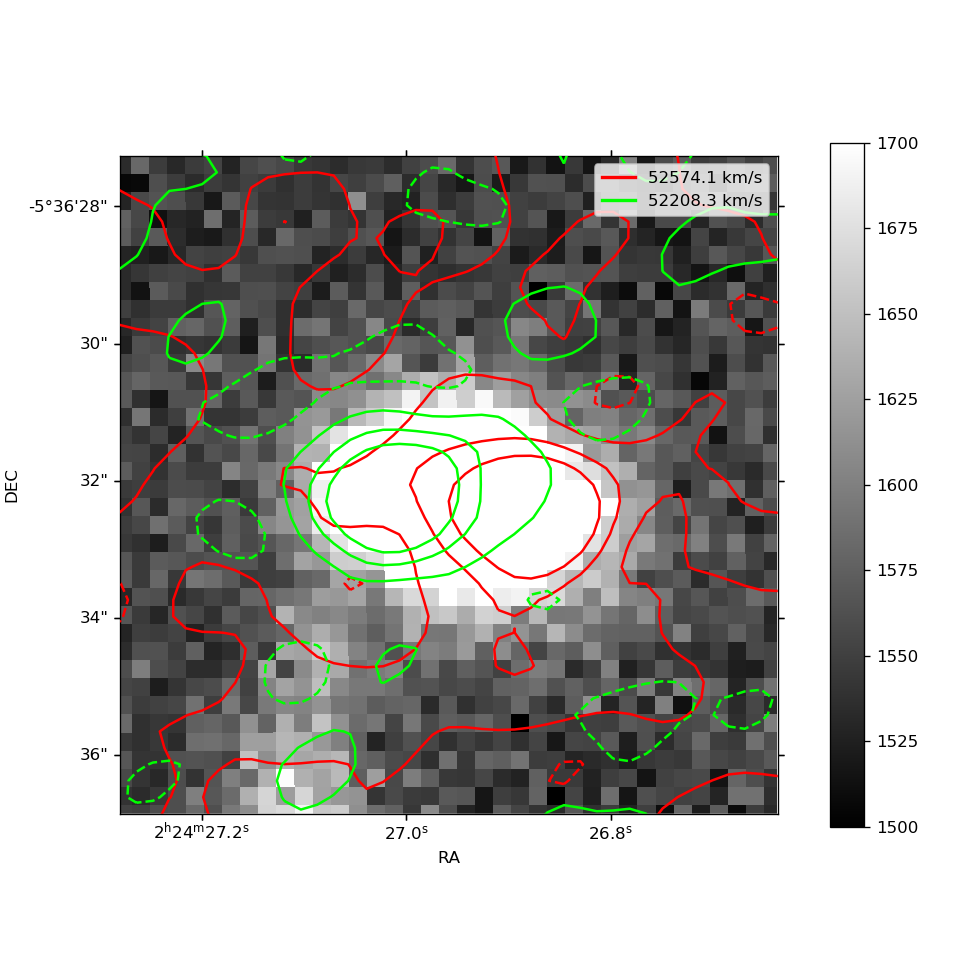

(88, 128)

In [25]:
opthdu = fits.open(xmm5_cubefiles[1])[0]
momhdu1 = fits.open(xmm5_cubefiles[4])[0]
momhdu2 = fits.open(xmm5_cubefiles[5])[0]

optwcs = wcs.WCS(opthdu.header)
momwcs = wcs.WCS(momhdu1.header)

momwcs = momwcs.sub(['celestial'])

%matplotlib notebook

momdata1 = momhdu1.data[0,0,:,:]
mommax1 = np.nanmax(momdata1)
momstd1 = np.nanstd(momdata1)
levels1 = np.ones(8)*mommax1
stds1 = np.arange(10, 2, step=-1)*momstd1
levels1 = (levels1 - stds1)

momdata2 = momhdu2.data[0,0,:,:]
mommax2 = np.nanmax(momdata2)
momstd2 = np.nanstd(momdata2)
levels2 = np.ones(8)*mommax2
stds2 = np.arange(10, 2, step=-1)*momstd2
levels2 = (levels2 - stds2)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=momwcs)
cs1 = ax.contour(momdata1, colors='red', levels=levels1)
cs2 = ax.contour(momdata2, colors='lime', levels=levels2)

custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='lime', lw=2)]

ax.legend(custom_lines, ['52574.1 km/s', '52208.3 km/s'])

xlim = ax.get_xlim()
ylim = ax.get_ylim()

opt_transform = ax.get_transform(optwcs)

im = ax.imshow(opthdu.data, cmap=plt.cm.gray, transform=opt_transform, vmin=1500, vmax=1700)

cbar = plt.colorbar(im, fraction=0.046, pad=0.07)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_xlim([88, 128])
ax.set_ylim([88, 128])

# SOURCE SEARCH ALGORITHM

In [8]:
from photutils import detect_sources, source_properties
#ref: https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.html#photutils.segmentation.SourceProperties
from scipy.special import factorial
from scipy.ndimage import rotate
from scipy.integrate import quad
from numpy.polynomial import polynomial as poly
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import ListedColormap
from astropy.visualization import astropy_mpl_style
from astropy.convolution import Tophat2DKernel
from math import floor
plt.style.use(astropy_mpl_style)
    

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


238


<IPython.core.display.Javascript object>


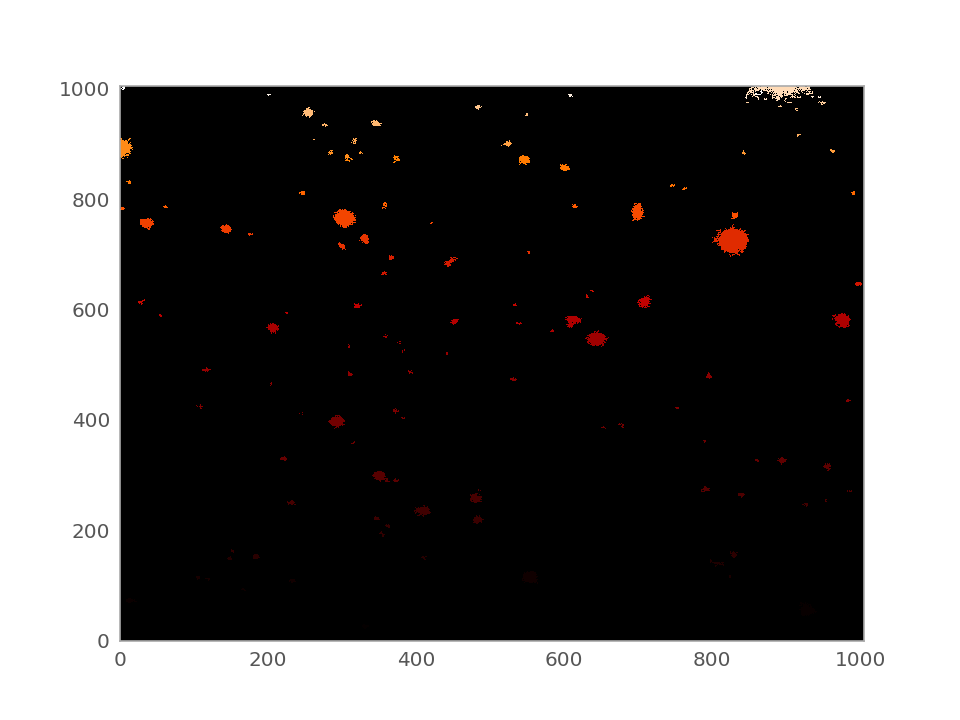

In [337]:
xmm5sources, xmm5blobs, xmm5perims, xmm5poss, xmm5data, cocoords = find_blobs(xmm5_cubefiles[5], xmm5_cubefiles[4], 30, 6, 12, 10)

In [338]:
len(xmm5poss)

293

In [339]:
resposs = np.array(xmm5poss)
print(len(np.where(resposs[:, 8] != -1)[0]))

matchidx = np.where(resposs[:,8] != -1)

matchchans = resposs[matchidx, 0][0]
matchchans = np.array([int(x) for x in matchchans])
matchchans

51


array([  4,  11,  22,  23,  25,  25,  28,  42,  43,  44,  53,  65,  68,
        69,  74,  75,  77,  78,  80,  87,  89,  90,  95, 101, 105, 105,
       106, 106, 125, 134, 134, 136, 140, 144, 148, 153, 159, 187, 188,
       188, 188, 189, 203, 209, 209, 212, 215, 223, 227, 234, 234])

<IPython.core.display.Javascript object>


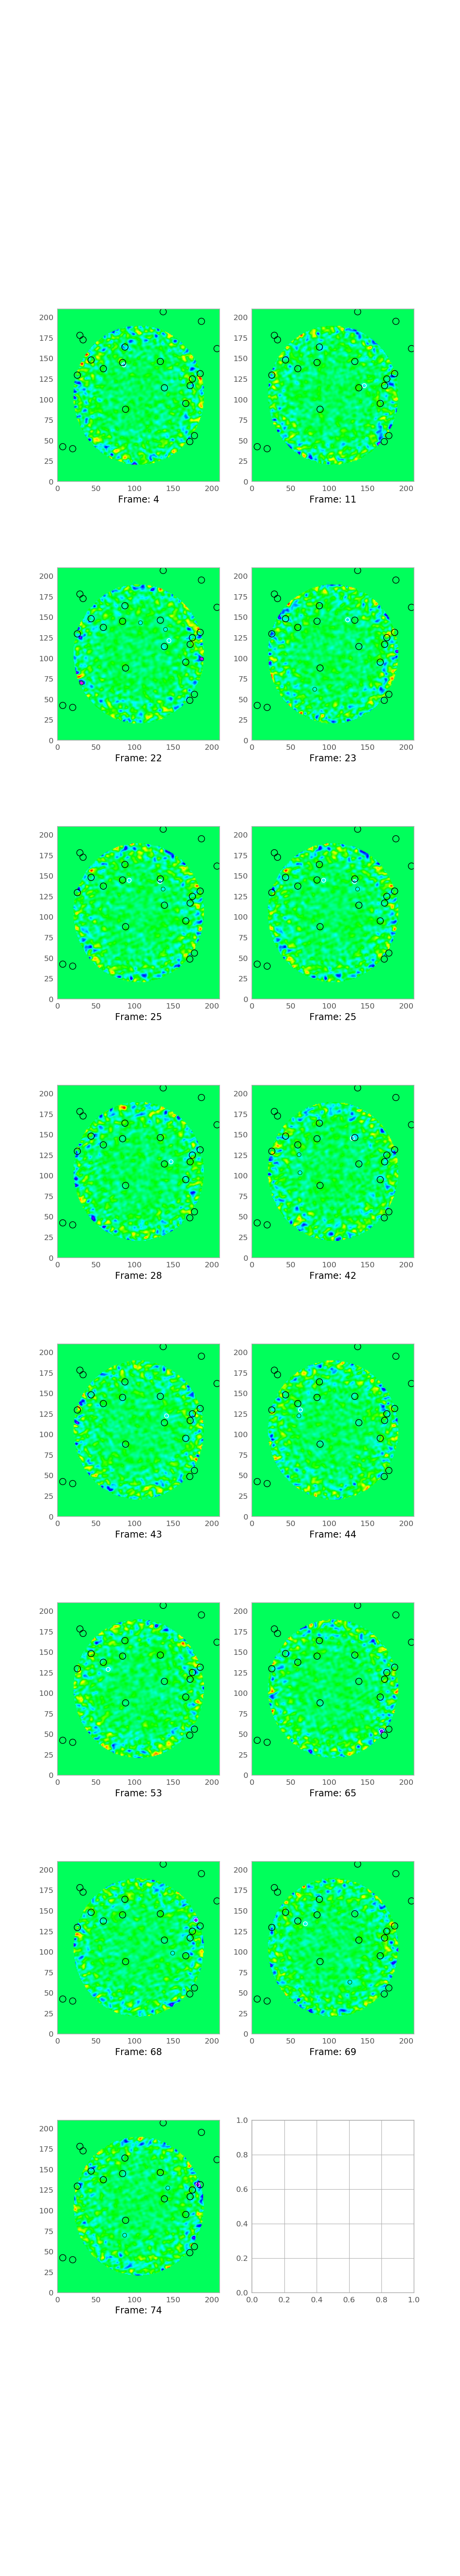

In [340]:
blobVisualize(xmm5data, xmm5poss, cocoords, matchchans[:15])

In [247]:
resposs

array([[ 0.00000000e+00,  9.05536788e+01,  6.35476598e+01, ...,
         4.06387635e-02,  2.60000000e+01, -1.00000000e+00],
       [ 0.00000000e+00,  1.22275763e+02,  1.40536410e+02, ...,
         2.65751518e-02,  1.90000000e+01,  3.00000000e+00],
       [ 1.00000000e+00,  1.14421014e+02,  1.49904435e+02, ...,
         1.59484297e-02,  1.20000000e+01,  5.00000000e+00],
       ...,
       [ 2.31000000e+02,  6.98415678e+01,  1.37994667e+02, ...,
         2.75310110e-02,  1.20000000e+01,  7.00000000e+00],
       [ 2.32000000e+02,  6.96331944e+01,  7.07040172e+01, ...,
         3.35933641e-02,  1.30000000e+01,  8.00000000e+00],
       [ 2.35000000e+02,  9.34543930e+01,  1.46162889e+02, ...,
         4.03763726e-02,  1.60000000e+01,  5.00000000e+00]])

In [9]:
def find_blobs(file, optfile, optT, nstds, npix, ndist):
    
    # find where the sources are in the optical file
    # read in optical data
    opthdul = fits.open(optfile)
    optsci = opthdul['PRIMARY'].data
    optwcs = wcs.WCS(opthdul[0].header)
    
    # read in co data
    hdul = fits.open(file)
    sci = hdul['PRIMARY'].data
    momwcs = wcs.WCS(hdul[0].header)        
    # get rid of the fourth dimension, which only has one entry
    sci = sci[0,:,:,:]
    
    sourcelist = []
    bloblist = []
    zzzpix = []
    
    fsize = sci.shape[1]
    nchannels = sci.shape[0]
    print(nchannels)
    r = 3.5 # isophotal extent
    
    optthresh = np.ones(optsci.shape)*optT
    
    optsources = detect_sources(optsci, optthresh, npix, connectivity=4)
    optcat = source_properties(optsci, optsources)
    
    %matplotlib notebook
    plt.pcolormesh(optsources)
    
    optcoords = []
    for optsource in optcat:
        optcoords.append([optsource.xcentroid.value, optsource.ycentroid.value])
        
    optcoords = np.array(optcoords)
  
    # use wcs to transfer the optical pixels into co pixels
    skycoords = wcs.utils.pixel_to_skycoord(optcoords[:,0], optcoords[:,1], optwcs)
    
    momcoords = skycoords.to_pixel(momwcs)
    momcoordsx, momcoordsy = momcoords[0], momcoords[1]
    momcoords = np.stack((momcoordsx, momcoordsy), axis=1)
    cocoords = momcoords[np.where(np.logical_and(np.logical_and(momcoordsx > 1, momcoordsx < fsize - 2),
                                                np.logical_and(momcoordsy > 1, momcoordsy < fsize - 2)))]

    
    # read properties of the sources into the empty array poss
            
    poss = []
    perims = []
    
    # first pass the nans to zeros to make the data useable
    sci[np.where(np.isnan(sci))] = 0.

    
    # loop through the channels of the cube. for each, make a threshold image using the mean and the standard
    # deviation (start with 2 sigma above mean) and then use photutils' detectsources to find large clumps
    for channel in range(sci.shape[0]):
        
        fm = sci[channel,:,:]
        
        # make a threshold image using a tophat kernel for now because the outer pixels are weighted more 
        # heavily in the images:

        # make the kernel 
        smallkern = Tophat2DKernel(50).array
        kern = np.zeros(np.shape(fm))
    
        val = round((fsize - smallkern.shape[0])/2 + 0.5)
        kern[(val - 1):-val, (val - 1):-val] = smallkern

        kern[np.where(kern != 0.)] = 1.
        outidx = np.where(kern == 0.)

        mean = np.mean(fm)

        innerpix = fm*kern
        instd = np.std(innerpix)

        outerpix = fm[outidx]
        outstd = np.std(outerpix)

        threshold = kern * (mean + (instd * nstds))
        threshold[outidx] = mean + (outstd * nstds)
        
        sources = detect_sources(fm, threshold, npix, connectivity=4) 
        if sources == None:
            continue
        
        cat = source_properties(fm, sources)
        
        sourcelist.append(sources)
        bloblist.append(cat)


        for n in range(len(cat)):

            coords = cat[n].coords
            totEl = np.sum(fm[coords]) #sum over each pixel in the frame belonging to the source
                                          # to find the total number of electrons making up the source

            size = len(coords[0])


            #fitted ellipse properties of the source
            a = cat[n].semimajor_axis_sigma.value * r
            b = cat[n].semiminor_axis_sigma.value * r
            theta = cat[n].orientation.value


            #centroid of the source in native (detector) pixels
            x = cat[n].xcentroid.value
            y = cat[n].ycentroid.value

            if np.isnan(x):
                x,y = np.mean(coords, axis=1)

            #ellipticity (1-a/b where a and b are the lengths of the semimajor and semiminor axes)
            #ref: https://photutils.readthedocs.io/en/stable/api/photutils.segmentation.SourceProperties.
            #       html#photutils.segmentation.SourceProperties.ellipticity
            ell = cat[n].ellipticity.value


            #read all values into the 'poss' array
            poss.append([channel, x, y, a, b, theta, totEl, size, -1])
            perims.append(cat[n].bbox.extent) #so surrounding pixels can be returned to be plotted


            #raise a warning if a source is returning no centroid
            if np.isnan(cat[n].xcentroid.value):
                print(file, channel)

            #END for n in cat
            
        # END for channel in file
        
        
    # mark sources that appear in the same spot (+/- ndist pix) as one of the co coordinates

    poss = np.array(poss)

    for n in range(len(poss)):
        x = poss[n,1]
        y = poss[n,2]
        
        for m in range(len(cocoords)):
            if cocoords[m,0] < (x+ndist) and cocoords[m,0] > (x-ndist) and cocoords[m,1] < (y+ndist) and cocoords[m,1] > (y-ndist):
                poss[n,8] = m
            

#         optmatchidx = np.where(np.logical_and(np.logical_and(cocoords[:,0] < (x+ndist), cocoords[:,0] > (x-ndist)),
#                               np.logical_and(cocoords[:,1] < (y+ndist), cocoords[:,1] > (x-ndist))))
#         optmatchidx = np.array(optmatchidx)

#         if optmatchidx[0].size > 0:
#             poss[n,8] = optmatchidx[0,0]




#     #mark sources that appear in the same spot (+/-ndist pix) across several frames with a 1 in the [n,10]th column
    
#     poss = np.array(poss)
    
#     for n in range(len(poss)):
    
#         x = poss[n,1]
#         y = poss[n,2]
        
#         if poss[n,7] > 25:
#             nd = ndist + 10
#         else:
#             nd = ndist

#         for m in np.arange(n+1, len(poss)):

#             if poss[m,1] < (x+nd) and poss[m,1] > (x-nd) and poss[m,2] < (y+nd) and poss[m,2] > (y-nd):
#                 poss[m,8] = n
#                 poss[n,8] = m
#                 continue
                
#             else:
#                 break
                
        

    return sourcelist, bloblist, perims, poss, sci, cocoords

In [10]:
def blobVisualize(data, poss, incoords, fms):
    
    %matplotlib notebook
    
    num = int(len(fms)/2 + 0.5)
    
    fig, axs = plt.subplots(num, 2, figsize=(10, num*7))
    
    vmin = np.min(data[fms,:,:])
    vmax = np.max(data[fms,:,:])
    
    for idx, n in enumerate(fms):
        
        i, j = divmod(idx, 2)
            
        fmdata = data[n,:,:]
        
        axs[i, j].pcolormesh(fmdata, cmap=plt.cm.gist_rainbow, vmin=vmin, vmax=vmax)
        
        axs[i, j].set_xlabel("Frame: {}".format(n))
        
        fmidx = np.where(poss[:,0] == n)[0]
        
        for sidx in fmidx:
                  
            sourcex = poss[sidx, 1]
            sourcey = poss[sidx, 2]
            
            rep = poss[sidx, 8]
            
            if rep == -1:
                ec = 'g'
            else:
                ec = 'white'
        
        
            axs[i, j].scatter(sourcex, sourcey, marker="o", facecolors='none', edgecolor=ec, s=40)
            
        axs[i, j].scatter(incoords[:,0], incoords[:,1], marker="o", facecolors='none', edgecolor='k', s=100)
        
        
    return

working on a search algorithm that finds sources in the same location in multiple consecutive frames

In [221]:
x = xmm5poss[5,1]
y = xmm5poss[5,2]

In [243]:
poss = xmm5poss
nd = 10
n = 1

x = poss[n, 1]
y = poss[n, 2]
chan = poss[n,0]

# find all entries farther along than n that are similar in (x,y) coordinates
xcond = np.logical_and(poss[n:,1] < x+nd, poss[n:,1] > x-nd)
ycond = np.logical_and(poss[n:,2] < y+nd, poss[n:,2] > y-nd)

potmatches = np.where(np.logical_and(xcond, ycond))[0] + n

# find the channels each potential match belongs
potchans = poss[potmatches,0]

for nchanidx in np.arange(1, 10):
    nextchan = np.where(potchans == chan + nchanidx)
    if nextchan[0].size > 0:
        poss[n,8] = nchanidx
        poss[potmatches[np.where(potchans == potchans[nextchan])], 8] = nchanidx
        continue
    else:
        print(nchanidx)
        break

# matchidx = potmatches[np.where(poss[potmatches, 0] != n)]

# poss[matchidx, 8] = n

# poss[np.where(poss[potmatches, 0] != n), 8]

1


# CO Mass Determination

## Process:
- first get Moment 0 map with CASA
- fit this to a 2D Gaussian (elliptical) - get FWHM for major and minor axes both
- use these to define a $4\sigma$ elliptical region about the center of the source in the full image cube
- get the spectral profile of the image cube in this region
- model this spectral profile with a Gaussian
- area under Gaussian is full integrated source flux

This should agree to a reasonable degree with the peak flux of the Moment map

In [11]:
# load in all files in the Galaxy's product cube directory
os.chdir('/home/ddunne/Documents/research/ALMA/2019.1.01529.S/XMM/XMM-5/product/cubes')

xmm5_cubefiles = glob.glob("*.fits")

xmm5_cubehduls = []
for i,file in enumerate(xmm5_cubefiles):
    with fits.open(file) as hdulist:
        xmm5_cubehduls.append(hdulist)
        print("{} {}".format(i, file))

0 member.uid___A001_X1465_X8db.XMM-5_sci.spw19.cube.I.pbcor.fits
1 member.uid___A001_X1465_X8db.XMM-5_sci.spw9.cube.I.pbcor.fits
2 member.uid___A001_X1465_X8db.XMM-5_sci.spw11.cube.I.pbcor.fits
3 DESopticalXMM5.fits
4 member.uid___A001_X1465_X8db.XMM-5_sci.spw19.repBW.I.pbcor.fits
5 member.uid___A001_X1465_X8db.XMM-5_sci.spw7.cube.I.pbcor.fits
6 xmmspw19mom0.fits


In [105]:
# get data from the moment 0 plot
hdul = fits.open(xmm5_cubefiles[6])
sci = hdul['PRIMARY'].data
momwcs = wcs.WCS(hdul[0].header)
sci = sci[0,0,:,:].astype('float64')

In [107]:
# pass the nans in the sci array to zeros
sci[np.where(np.isnan(sci))] = 0.

In [21]:
print('Maximum flux value from Moment 0 plot (Jy/beam*km/s) :')
print(np.nanmax(sci))

Maximum flux value from Moment 0 plot (Jy/beam*km/s) :
0.9050939


In [134]:
def gaussian_2d(x, amp, mean, std, theta):
    # two dimensional elliptical gaussian PDF with 2D offset and rotation
    # x, mean, std and offset should all be arrays of the form [x, y]
    
    # extend all of the other arrays to the coordinate meshgrid
    extarr = np.ones(np.shape(x)[:2])
    ampext = amp*extarr
    
    extarr = np.stack((extarr, extarr), axis=2)
    meanext = extarr*mean
    stdext = extarr*std
    rotext = np.stack(((x[:,:,0]*np.cos(theta) - x[:,:,1]*np.sin(theta)),
                      x[:,:,0]*np.sin(theta) + x[:,:,1]*np.cos(theta)), axis=2)

    
    # two dimensional gaussian function
    gauss = amp*np.exp(-np.sum(((mean - rotext)/std)**2, axis=2)/2)
    
    return gauss

In [103]:
scix = np.arange(np.shape(sci)[0])
scicoords = np.stack(np.meshgrid(scix, scix), axis=2).astype('float64')

In [113]:
means = np.array([108,108], dtype='float64')
stds = np.array([6,2], dtype='float64')

In [136]:
opt,cov = curve_fit(gaussian_2d, scicoords, sci, p0=(0.09, means, stds, 0.01))

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

<IPython.core.display.Javascript object>


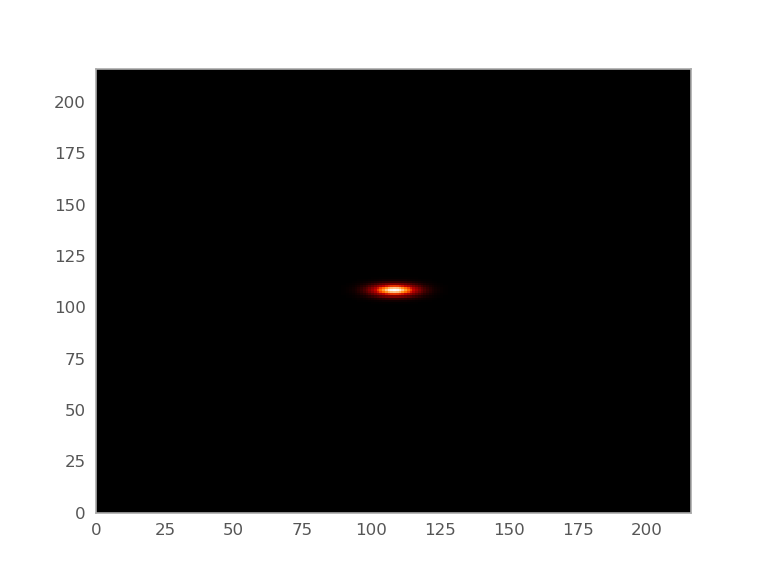

In [138]:
%matplotlib notebook
plt.pcolormesh(gaussian_2d(scicoords, 0.01, means, stds, 0))

In [130]:
np.where(gaussian_2d(scicoords, 1, means, stds, 0) < 2500)

(array([], dtype=int64), array([], dtype=int64))

In [83]:
arr = np.linspace(-10, 10, num=100)
xarr, yarr = np.meshgrid(arr, arr)

xyarr = np.stack((xarr, yarr), axis=2)

In [84]:
test = np.array([1,2])

In [85]:
tarr = gaussian_2d(xyarr, 1, test, test, 1)

<IPython.core.display.Javascript object>


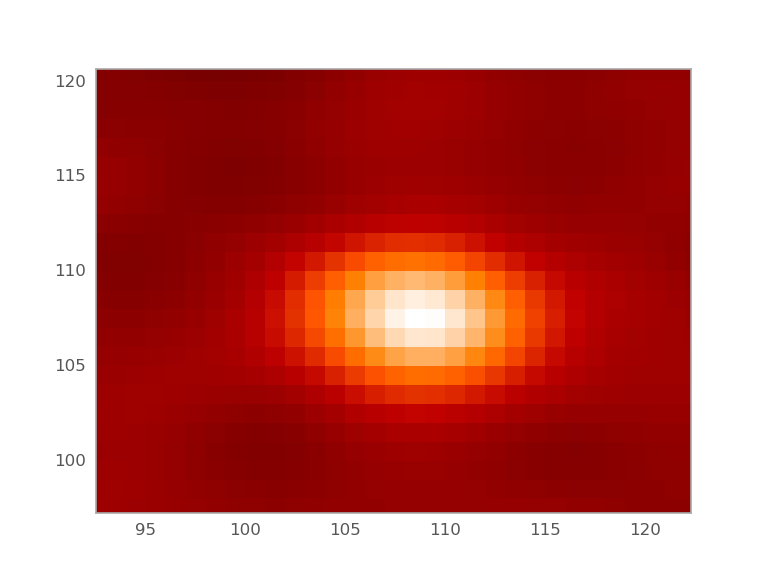

In [93]:
%matplotlib notebook 
plt.pcolormesh(sci)

In [69]:
theta = 0.5
rotmat = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

In [72]:
rotmat@xyarr

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 2)